In [1]:
%cd /notebooks/kaggle-garbage-classification
!source .env3/bin/activate
!pip install -U fastai
!pip install -U fastcore

/notebooks/kaggle-garbage-classification


/notebooks/kaggle-garbage-classification/.env3/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch
print(torch.__version__)  # Versão do PyTorch
print(torch.version.cuda)  # Versão do CUDA

2.5.1+cu118
11.8


In [3]:
from fastcore.xtras import Path
from fastai.vision.all import *
from PIL import Image

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
root_path = Path("/notebooks/kaggle-garbage-classification")
data_path = Path(root_path/"data")
data_path.ls()

(#7) [Path('/notebooks/kaggle-garbage-classification/data/metal'),Path('/notebooks/kaggle-garbage-classification/data/trash'),Path('/notebooks/kaggle-garbage-classification/data/glass'),Path('/notebooks/kaggle-garbage-classification/data/cardboard'),Path('/notebooks/kaggle-garbage-classification/data/paper'),Path('/notebooks/kaggle-garbage-classification/data/plastic'),Path('/notebooks/kaggle-garbage-classification/data/.ipynb_checkpoints')]

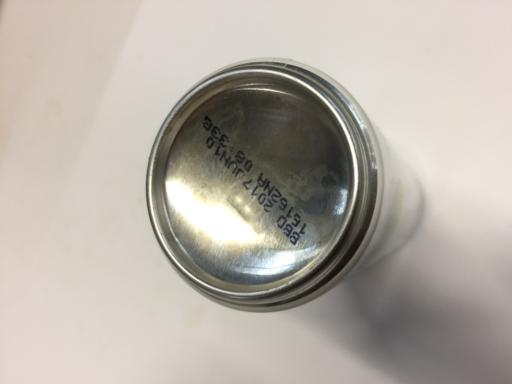

In [6]:
im_path = (data_path/'metal').ls()[0]
im = Image.open(im_path)
im

In [7]:
bad_imgs = []
classes = ['metal', 'trash', 'glass', 'cardboard', 'paper', 'plastic']
for c in classes:
    for im in (data_path/c).ls():
        try:
            _ = Image.open(im)
        except:
            bad_imgs.append(im)
            im.unlink()
bad_imgs, len(bad_imgs)

([], 0)

In [8]:
fnames = get_image_files(data_path)
fnames

(#2527) [Path('/notebooks/kaggle-garbage-classification/data/metal/metal145.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal344.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal66.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal204.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal293.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal282.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal303.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal308.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal57.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal128.jpg')...]

## DataBlocks

In [9]:
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.)),
    batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [10]:
dls = data_block.dataloaders(data_path, bs=64, device=device)
dls

In [11]:
dls.vocab

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [12]:
dls.vocab.o2i

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [13]:
learn = vision_learner(dls, resnet34, metrics=error_rate, path=root_path)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 174MB/s]


In [14]:
#learn.lr_find()

In [15]:
learning_rate = 0.0006918309954

In [25]:
import ipynbname
notebook_name = ipynbname.name()
model_name = notebook_name + 'best_model'

In [27]:
from fastai.callback.tracker import SaveModelCallback

# Treinamento com salvamento automático dos melhores pesos
learn.fine_tune(
    50,  # Número máximo de épocas
    base_lr=3e-3,
    cbs=[
        SaveModelCallback(monitor='valid_loss', fname=model_name),  # Salva os melhores pesos baseados em 'valid_loss'
        EarlyStoppingCallback(monitor='valid_loss', patience=5)  # Early stopping opcional
    ]
)

epoch,train_loss,valid_loss,error_rate,time
0,0.131160,0.431376,0.114851,00:10


Better model found at epoch 0 with valid_loss value: 0.4313758909702301.


epoch,train_loss,valid_loss,error_rate,time
0,0.130455,0.364882,0.106931,00:12
1,0.115797,0.381485,0.093069,00:12
2,0.092936,0.407213,0.097030,00:12
3,0.080078,0.378579,0.097030,00:12
4,0.072910,0.348030,0.089109,00:12
5,0.081181,0.471734,0.104950,00:12
6,0.083199,0.354566,0.104950,00:12
7,0.093279,0.458913,0.097030,00:12
8,0.094184,0.459496,0.122772,00:12
9,0.090897,0.467434,0.110891,00:12


Better model found at epoch 0 with valid_loss value: 0.3648820221424103.
Better model found at epoch 4 with valid_loss value: 0.34802988171577454.
No improvement since epoch 4: early stopping


In [28]:
# learn.path = root_path
# learn.path

In [29]:
#learn.save('fastai-Datablock')

In [30]:
learn.load(model_name, device=device)

/notebooks/kaggle-garbage-classification/.env3/lib/python3.11/site-packages/fastai/learner.py:61: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


## Predict

('cardboard',
 tensor(0),
 tensor([9.9996e-01, 3.1011e-07, 6.8159e-07, 4.0769e-05, 1.6564e-07, 4.1989e-07]))

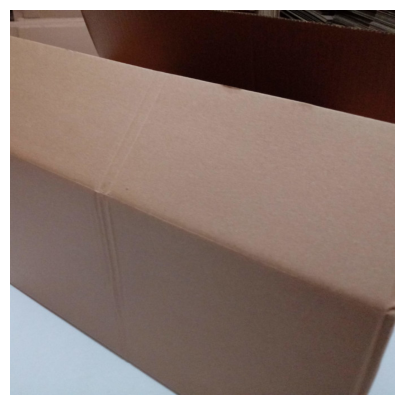

In [31]:
im_path = Path(root_path/'caixa-papelao-grande-50-c-x-26-l-x-26-a-kit-20-unidades-caixa-papelao-correio.jpg')
im = Image.open(im_path)
show_image(im); learn.predict(im_path)

In [32]:
learn.predict(im_path)

('cardboard',
 tensor(0),
 tensor([9.9996e-01, 3.1011e-07, 6.8159e-07, 4.0769e-05, 1.6564e-07, 4.1989e-07]))

('glass',
 tensor(1),
 tensor([7.3024e-03, 7.9300e-01, 1.3934e-03, 6.0689e-04, 1.9739e-01, 3.0776e-04]))

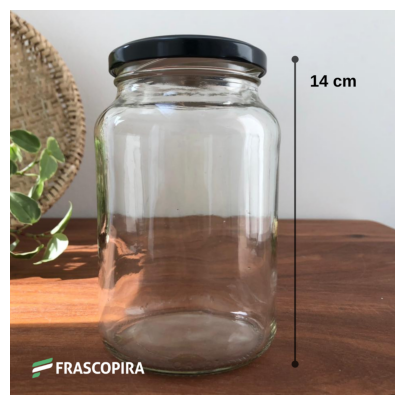

In [33]:
im_path = Path(root_path/'pote_vidro_500g_com_tampa_74_mm_preta.png')
im = Image.open(im_path)
show_image(im); learn.predict(im_path)